# Data Science and Visualization (RUC F2025)

## Miniproject Report

## Project Title: Predicting Podcast Listening Time. Kaggle Competition.

## Group Members:
* Vladyslav Horbatenko, Computer Science and Mathematics, 2025, vladyslav@ruc.dk

## Abstract

[Here, you need to write ~5 sentences to describe the main points of your project, including but not limited to, dataset, research questions, data science methods, findings from the data, your condlusions and remarks.]

## 0. Setup and Data

Import the modules needed for the project.

In [194]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.dummy import DummyRegressor


---
### Data Description

The dataset used in this report comes from the Kaggle Playground Series S5E4 competition (https://www.kaggle.com/competitions/playground-series-s5e4/data). According to the competition organizers, it was generated by a deep learning model trained on the [Podcast Listening Time Prediction](https://www.kaggle.com/datasets/ysthehurricane/podcast-listening-time-prediction-dataset/) dataset. As a result, the feature distributions closely mirror—but do not exactly match—the originals.

In this report, I will demonstrate the train/test split using the original dataset; however, all exploratory data analysis (EDA) and model training are conducted on the competition dataset.

#### Files

- **train.csv** – Training data; the target variable is `Listening_Time_minutes`.  
- **test.csv** – Test data; your goal is to predict `Listening_Time_minutes` for each entry.  
- **sample_submission.csv** – Example submission file in the correct format.  

#### Reference

Walter Reade and Elizabeth Park. *Predict Podcast Listening Time*. Kaggle Competition: Playground Series S5E4. 2025. https://www.kaggle.com/competitions/playground-series-s5e4

---

## 1. Loading the Data

While the Kaggle API can be used to fetch these files programmatically, for simplicity we will download them directly from the competition page and save them into a local `data/` folder. As an alternative—particularly useful if the competition data changes—you can clone my GitHub repository, which always contains the latest version: https://github.com/rifolio/PodcastWatchTimePrediction

[Below you should load the data, display a part of the data, show the shape (number of rows and that of columns) of the data, and show the statistics of the data.]

I will start by loading original dataset using pandas `read_csv` method, and `train_test_split` to split it into train and test and submission dataframes, to showcase logic that organizers used to create such split

In [195]:
# loading origin dataset
original_data = pd.read_csv('data/podcast_dataset.csv')

# making sure no missing values are present in the target variable
original_data = original_data.dropna(subset=['Listening_Time_minutes'])

# adding an ID column as it doesn't exist in original dataset
original_data = original_data.reset_index().rename(columns={'index': 'ID'})

# randomly selcting 1,000 rows for submission
submission = original_data.sample(n=1000, random_state=42)[['ID', 'Listening_Time_minutes']]


# features (X) and target (y)
X = original_data.drop(columns=['Listening_Time_minutes'])
y = original_data['Listening_Time_minutes']

# train-test split for rest of data with 20/80 split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Submission set size:", submission.shape)
print("Training set size:", X_train.shape)
print("Validation set size:", X_valid.shape)

Submission set size: (1000, 2)
Training set size: (14072, 11)
Validation set size: (3518, 11)


This demonstrates how we could simulate a train/test/submission split from the original dataset. However, since the competition dataset is more extensive and better aligned with the task requirements (albeit synthetically generated), I will use the official competition split for all further analysis and modeling combined with `podcast_dataset.csv` with train split

In [196]:
test = pd.read_csv('data/test.csv') 
train_df = pd.read_csv('data/train.csv')
submission = pd.read_csv('data/sample_submission.csv')

# combining train and original data
train_df = pd.concat([train_df, original_data], ignore_index=True)
train_df.drop(columns=['id', 'ID'], inplace=True)

# Drop duplicate samples
train = train_df.drop_duplicates()

In [197]:
# overall statistics about data
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Submission shape:", submission.shape)

Train shape: (767590, 11)
Test shape: (250000, 11)
Submission shape: (250000, 2)


In [198]:
train.dtypes

Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

In [199]:
train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,678727.000000,767590.000000,619834.000000,767589.000000,767590.000000
mean,64.466083,59.866318,52.181816,1.352360,45.437908
std,32.971460,22.880310,28.460765,1.150496,27.137015
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.710000,39.430000,28.290000,0.000000,23.180910
50%,63.820000,60.060000,53.460000,1.000000,43.390230
75%,94.040000,79.540000,76.560000,2.000000,64.804950
max,325.240000,119.460000,119.910000,103.910000,119.970000


In [200]:
test.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,250000.000000,2.212640e+05,250000.000000,201168.000000,250000.000000
mean,874999.500000,4.192987e+02,59.716491,52.192796,1.355852
std,72168.927986,1.668545e+05,22.880028,28.445034,4.274399
min,750000.000000,2.470000e+00,2.490000,0.000000,0.000000
25%,812499.750000,3.578000e+01,39.250000,28.320000,0.000000
50%,874999.500000,6.397000e+01,59.900000,53.360000,1.000000
75%,937499.250000,9.415000e+01,79.390000,76.560000,2.000000
max,999999.000000,7.848626e+07,117.760000,116.820000,2063.000000


## 2. Data Preprocessing and Exploratory Data Analysis

[Below you should handle the missing values, convert data types, apply data scaling and so on, if any of them is needed.]

Since competition have already provided us with `train` and `test` datasets, I will mainly focus on `train` dataset in the analysis. But will also compare their distributions, and appply same pre-processing logic.

### Handling Missing Values

In [201]:
# for usability, I will define function that shows missing values in a any dataframe
def show_missing(df, name="DataFrame"):
    missing = df.isnull().sum() 
    missing_percent = df.isnull().mean()

    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': (missing_percent * 100).round(2)
    })

    # only showing column that have missing values
    missing_df = missing_df[missing_df['Missing Count'] > 0]

    if missing_df.empty:
        print(f"No missing values in {name}.")
    else:
        print(f"Missing values in {name}:")
        print(missing_df.sort_values(by="Missing Count", ascending=False))

show_missing(train, "Train Set")
show_missing(test, "Test Set")


Missing values in Train Set:
                             Missing Count  Missing %
Guest_Popularity_percentage         147756      19.25
Episode_Length_minutes               88863      11.58
Number_of_Ads                            1       0.00
Missing values in Test Set:
                             Missing Count  Missing %
Guest_Popularity_percentage          48832      19.53
Episode_Length_minutes               28736      11.49


#### Episode Duration

A notable portion of `Episode_Length_minutes` is missing, making imputation necessary to avoid losing valuable data. While the **global median** is a common method that is less affected by outliers, it may overlook podcast-specific patterns.

Since podcasts often follow consistent episode durations, i need to evaluate whether **per-podcast medians** vary significantly (its STD).

In [202]:
# global median
global_median = train['Episode_Length_minutes'].median()

# median per podcast
podcast_medians = train.groupby('Podcast_Name')['Episode_Length_minutes'].median()
median_std = podcast_medians.std()

print("Global median:", global_median)
print("Std of medians per podcast:", median_std)

Global median: 63.82
Std of medians per podcast: 2.2207980658317688


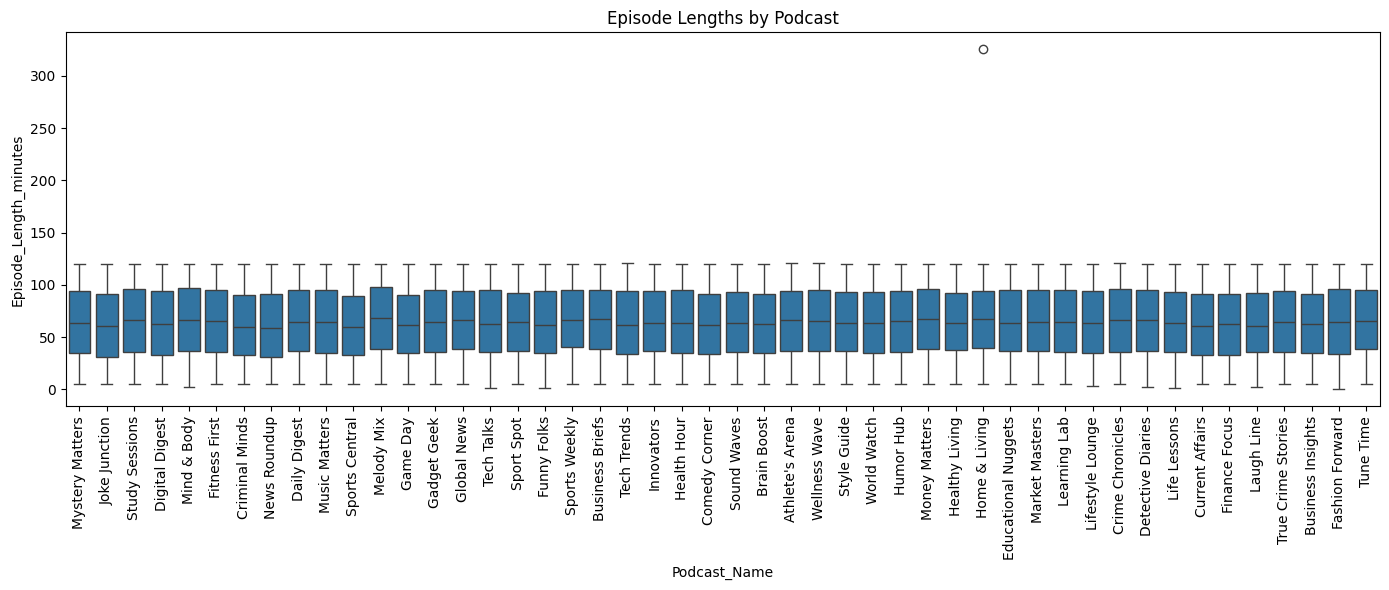

In [203]:
# boxplot of episode lengths for all podcasts
plt.figure(figsize=(14, 6))
sns.boxplot(data=train, x='Podcast_Name', y='Episode_Length_minutes')

plt.xticks(rotation=90)
plt.title("Episode Lengths by Podcast")
plt.tight_layout()
plt.show()


Now I can see that both, data and plot shows that variation across podcast medians is small (std = 2.22), and the global distribution is well-centered.

Meaning that imputing missing values with the **global median** is justified.


In [204]:
median_length = train['Episode_Length_minutes'].median()
train['Episode_Length_minutes'] = train['Episode_Length_minutes'].fillna(median_length)
test['Episode_Length_minutes'] = test['Episode_Length_minutes'].fillna(median_length)

#### Guest Popularity

`Guest_Popularity_percentage` has ~19% missing values. To decide how to impute them, I will analyse the impact of missing guest data on listening behavior.

In [205]:
# making temporary copy of train set to analyze missing values
temp = train.copy()
temp['Guest_Missing'] = temp['Guest_Popularity_percentage'].isna().astype(int)

# listening time with and without missing guest info
summary = temp.groupby('Guest_Missing')['Listening_Time_minutes'].describe()
display(summary)


,count,mean,std,min,25%,50%,75%,max
Guest_Missing,,,,,,,,
0,619834.0,45.474773,27.173711,0.0,23.09894,43.29822,64.83828,119.97
1,147756.0,45.283261,26.982078,0.0,23.42442,43.67298,64.58644,119.97


The distributions of `Listening_Time_minutes` are almost identical across both groups. Mening that missing guest popularity is likely just incomplete data.

So, we can also use median per podcast or global median. Like in eposide length time, I will use global median.


In [206]:
guest_median = train['Guest_Popularity_percentage'].median()

# fill in nans
train['Guest_Popularity_percentage'] = train['Guest_Popularity_percentage'].fillna(guest_median)
test['Guest_Popularity_percentage'] = test['Guest_Popularity_percentage'].fillna(guest_median)


As I only have one missing value for `Number_of_Ads`, removal of will not have big impact on results, so I will just drop it.

In [207]:
train = train[train['Number_of_Ads'].notna()]
test = test[test['Number_of_Ads'].notna()]

Lets now check datasts summary again:

In [208]:
show_missing(train, "Train Set")
show_missing(test, "Test Set")

No missing values in Train Set.
No missing values in Test Set.


## Values Pre-processing

In [209]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 767589 entries, 0 to 767589
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 767589 non-null  object 
 1   Episode_Title                767589 non-null  object 
 2   Episode_Length_minutes       767589 non-null  float64
 3   Genre                        767589 non-null  object 
 4   Host_Popularity_percentage   767589 non-null  float64
 5   Publication_Day              767589 non-null  object 
 6   Publication_Time             767589 non-null  object 
 7   Guest_Popularity_percentage  767589 non-null  float64
 8   Number_of_Ads                767589 non-null  float64
 9   Episode_Sentiment            767589 non-null  object 
 10  Listening_Time_minutes       767589 non-null  float64
dtypes: float64(5), object(6)
memory usage: 70.3+ MB


## 3. Exploratory Data Analysis

[Below you can conduct EDA of your data, e.g., ask some questions and try to answer them by accessing the data properly and making some visualizations.]

## 4. Data Modelling

[Below you apply machine learning models and other data science methods to your data, e.g., classification, regression, clustering, and association rule mining. You should do at least one of them. Give a description of what you do here.]

### 4.1. Feature Selection

[Decide which features you want to use and obtain them properly from the original data.]

### 4.2 Model Construction and Validation

[Construct the model and validate the model design if necessary.]

### 4.3 Model Application and Performance Evaluation

[Apply the model and evaluate its performance]

### 4.4 Visualize and Analyze Your Results/Findings from Data Modelling

[Here you may visualize the modeling results, and/or analyze/interprete its meanings.]

## 5. Conclusion and Discussion

[Here you may draw your conclusion based on the previous sections, and discuss the pros and cons of the project, and propose something for future work.]